In [81]:
import numpy as np
import cv2
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [71]:
data = pd.read_csv("features.csv")
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Labels,0,1,2,3,4,5,6,7,8,...,134,135,136,137,138,139,140,141,142,143
0,contempt,12672332,8772521,7238421,5995195,79371608,6465355,1295269876,439270975,680850588,...,8021325,9852713,9331058,9447333,6330290,3699293,4642420,10129684,10169247,9574443
1,happy,4500054,3047645,2692774,2068007,76945247,2952174,473569862,327629842,269900878,...,6107835,9324823,8634703,8730238,3501184,2944482,2761722,9927187,10059357,9036383
2,surprise,9722714,6746843,5591823,4621194,72330520,5157757,1028484904,366664391,544533520,...,7761974,9798409,9229635,9385976,5603346,3328441,4105022,10090091,10156789,9306832
3,sadness,11937332,8321254,6835628,5674864,71557866,6092957,1208334713,434532326,649221173,...,7539927,9872527,9230115,9410328,5951611,3599522,4400985,10124678,10166640,9278121
4,surprise,12259220,8523867,6987521,5811509,71545689,6133874,1249735568,421561669,663081481,...,8888416,10167863,10082984,10098437,6528232,3688813,4760835,10193883,10197458,9883788


In [72]:
labels = data.pop("Labels").to_numpy()
features = data.to_numpy()

In [73]:
target_dict={k: v for v, k in enumerate(np.unique(labels))}
target_val=  [target_dict[labels[i]] for i in range(len(labels))]
target_dict

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'sadness': 5,
 'surprise': 6}

In [74]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=25)

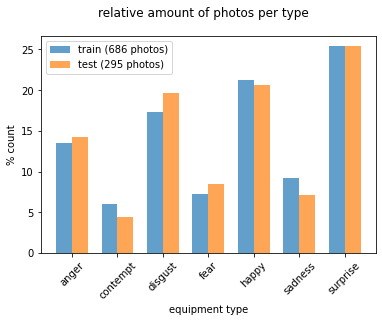

In [75]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

In [76]:
sc = StandardScaler()
pca = PCA(35)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [77]:
%%time
param_grid = [
    {'n_neighbors':[8,15,22,29,36,43], 'weights':['uniform', 'distance'], 'p':[1,2,3,5,7,9,11], 'algorithm':['ball_tree','kd_tree','brute','auto']},
]

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, param_grid)
clf.fit(X_train, y_train)

CPU times: user 1min 12s, sys: 2.16 s, total: 1min 14s
Wall time: 1min 15s


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree', 'brute',
                                        'auto'],
                          'n_neighbors': [8, 15, 22, 29, 36, 43],
                          'p': [1, 2, 3, 5, 7, 9, 11],
                          'weights': ['uniform', 'distance']}])

In [79]:
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.92      0.83      0.88        42
    contempt       0.76      1.00      0.87        13
     disgust       0.78      0.81      0.80        58
        fear       0.77      0.80      0.78        25
       happy       0.75      0.77      0.76        61
     sadness       0.64      0.67      0.65        21
    surprise       0.91      0.84      0.87        75

    accuracy                           0.81       295
   macro avg       0.79      0.82      0.80       295
weighted avg       0.82      0.81      0.81       295



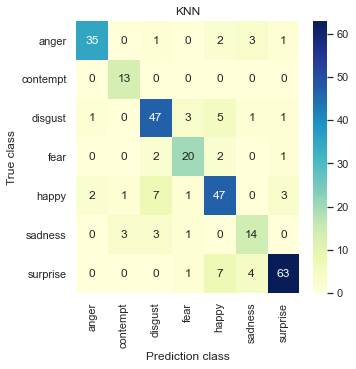

In [84]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=['anger','contempt','disgust','fear','happy','sadness','surprise'])
cm_df = pd.DataFrame(cm, index=['anger','contempt','disgust','fear','happy','sadness','surprise'], columns=['anger','contempt','disgust','fear','happy','sadness','surprise'])

import seaborn as sns
sns.set_theme()
plt.figure(figsize = (5,5))
sns.heatmap(cm_df, annot = True,cmap='YlGnBu',cbar=True)
plt.title('KNN')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()